In [10]:
# =============================================================================
# STEP 1+2 CORRETTO: Load data, split PRIMA, poi vettorizza
# =============================================================================
import sys
sys.path.append("../source")
from src import stratified_split, truncated_svd

import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

# 1. Load cleaned text data
df_supervised = pd.read_csv("./clean_supervised.csv")
df_supervised = df_supervised.dropna(subset=['body_clean'])

# 2. Group by author
df_grouped = df_supervised.groupby('author')['body_clean'].apply(" ".join).reset_index()
df_grouped = df_grouped.rename(columns={'body_clean': 'body'})

# 3. Load and match labels
target_df = pd.read_csv("./Data/target_supervised.csv")
labels = []
for auth in df_grouped['author']:
    match = target_df[target_df['author'] == auth]
    if not match.empty:
        labels.append(match['gender'].iloc[0])
    else:
        labels.append(None)

df_grouped['label'] = labels
df_grouped = df_grouped.dropna(subset=['label'])
print(f"Dataset size: {len(df_grouped)} authors")

# 4. SPLIT PRIMA della vettorizzazione! (questo evita data leakage)
X_text = df_grouped['body'].values
y = df_grouped['label'].values

X_text_train, X_text_val, X_text_test, y_train, y_val, y_test = stratified_split(X_text, y)
print(f"Train: {len(X_text_train)}, Val: {len(X_text_val)}, Test: {len(X_text_test)}")

# 5. BoW - fit SOLO su train
bow_vectorizer = CountVectorizer(min_df=5, max_df=0.99)
X_bow_train = bow_vectorizer.fit_transform(X_text_train)
X_bow_val = bow_vectorizer.transform(X_text_val)
X_bow_test = bow_vectorizer.transform(X_text_test)
print(f"BoW vocabulary size: {len(bow_vectorizer.vocabulary_)}")

# 6. TF-IDF - fit SOLO su train
tfidf_vectorizer = TfidfVectorizer(min_df=5, max_df=0.99)
X_tfidf_train = tfidf_vectorizer.fit_transform(X_text_train)
X_tfidf_val = tfidf_vectorizer.transform(X_text_val)
X_tfidf_test = tfidf_vectorizer.transform(X_text_test)
print(f"TF-IDF vocabulary size: {len(tfidf_vectorizer.vocabulary_)}")

# 7. SVD - fit SOLO su train
X_bowsvd_train, X_bowsvd_val, X_bowsvd_test = truncated_svd(X_bow_train, X_bow_val, X_bow_test)
X_tfidfsvd_train, X_tfidfsvd_val, X_tfidfsvd_test = truncated_svd(X_tfidf_train, X_tfidf_val, X_tfidf_test)

# Le variabili per la Logistic Regression sono ora pronte:
# - X_bowsvd_train, X_bowsvd_val, X_bowsvd_test
# - X_tfidfsvd_train, X_tfidfsvd_val, X_tfidfsvd_test
# - y_train, y_val, y_test (uguali per entrambi)

# Alias per compatibilità con il codice esistente
y_bowsvd_train = y_train
y_bowsvd_val = y_val
y_bowsvd_test = y_test
y_tfidfsvd_train = y_train
y_tfidfsvd_val = y_val
y_tfidfsvd_test = y_test

print("\n✅ Dati pronti per la Logistic Regression!")

Dataset size: 4942 authors
Train: 3952, Val: 495, Test: 495
BoW vocabulary size: 21207
TF-IDF vocabulary size: 21207

✅ Dati pronti per la Logistic Regression!


# LOGISTICAL REGRESSION
## ML Model Training and Evaluation.
### a. Choose at least 3 ML methods. Perform model training with the default parameter
configuration, evaluate the performance on both training and test set. Output the
confusion matrix and classification report. Which model generates the best performance?
### b. Do you observe overfitting or under-fitting? If so, why does this happen and how to deal
with this issue?
### c. Tune the hyper-parameters of the models through cross-validation. How does performance
vary? What is your choice of the best model and hyper-parameter according to training
cost (you can use training time as a proxy for “cost”) and performance?

In [11]:
# IMPORT VARI
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


--- BOW SVD : Analysis ---

PERFORMANCE - TRAINING SET:
              precision    recall  f1-score   support

           0       0.97      0.92      0.94      2888
           1       0.80      0.91      0.85      1064

    accuracy                           0.92      3952
   macro avg       0.88      0.91      0.90      3952
weighted avg       0.92      0.92      0.92      3952

PERFORMANCE - VALIDATION SET:
              precision    recall  f1-score   support

           0       0.87      0.83      0.85       362
           1       0.59      0.66      0.62       133

    accuracy                           0.78       495
   macro avg       0.73      0.75      0.74       495
weighted avg       0.79      0.78      0.79       495



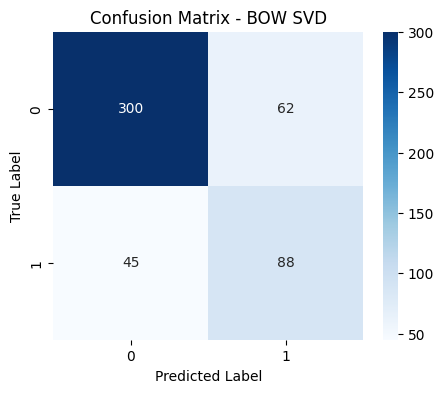

--- TF-IDF SVD : Analysis ---

PERFORMANCE - TRAINING SET:
              precision    recall  f1-score   support

           0       0.94      0.88      0.91      2888
           1       0.72      0.85      0.78      1064

    accuracy                           0.87      3952
   macro avg       0.83      0.86      0.84      3952
weighted avg       0.88      0.87      0.87      3952

PERFORMANCE - VALIDATION SET:
              precision    recall  f1-score   support

           0       0.90      0.86      0.88       362
           1       0.66      0.73      0.70       133

    accuracy                           0.83       495
   macro avg       0.78      0.80      0.79       495
weighted avg       0.83      0.83      0.83       495



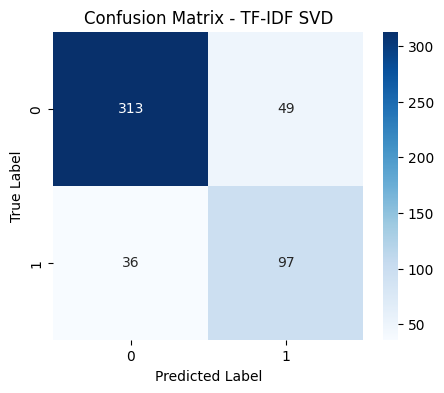

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

def train_and_evaluate(X_train, y_train, X_val, y_val, dataset_name="Dataset"):
    print(f"--- {dataset_name} : Analysis ---")

    # 1. Initialization
    # class_weight='balanced' since there are a lot of men
    model = LogisticRegression(random_state=16, max_iter=2000, class_weight='balanced')

    # 2. Fitting Phase
    model.fit(X_train, y_train)

    # 3. Prediction Phase
    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_val)

    # 4. Debug
    print("\nPERFORMANCE - TRAINING SET:")
    print(classification_report(y_train, y_pred_train))

    print("PERFORMANCE - VALIDATION SET:")
    print(classification_report(y_val, y_pred_val))

    # 5. Confusion Matrix (Validation)
    cm = confusion_matrix(y_val, y_pred_val)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {dataset_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    return model

# Esegui la funzione sul tuo dataset TF-IDF ridotto con SVD (di solito il migliore)
# Nota: assicurati di passare i vettori y corretti
log_reg_model_bow = train_and_evaluate(X_bowsvd_train, y_bowsvd_train, X_bowsvd_val, y_bowsvd_val, "BOW SVD")
log_reg_model_tfidf = train_and_evaluate(X_tfidfsvd_train, y_tfidfsvd_train, X_tfidfsvd_val, y_tfidfsvd_val, "TF-IDF SVD")

### NOTE
Looking at the two plotting of the confusion matrix, we can draw that the tf-idf svd dataset give us better results in terms of TP, TN, FP, FN...

# --- Analisi per: BOW SVD ---

## PERFORMANCE SUL TRAINING SET:
              precision    recall  f1-score   support

           0       0.97      0.92      0.94      2888
           1       0.80      0.91      0.85      1064

    accuracy                           0.92      3952
   macro avg       0.88      0.91      0.90      3952
weighted avg       0.92      0.92      0.92      3952

## PERFORMANCE SUL VALIDATION SET:
              precision    recall  f1-score   support

           0       0.87      0.83      0.85       362
           1       0.59      0.66      0.62       133

    accuracy                           0.78       495
   macro avg       0.73      0.75      0.74       495
weighted avg       0.79      0.78      0.79       495

### NOTE
In this case we can see that the support demonstrate that there are a lot more men (we knew it) like three times more.
Then, we have to consider that the accuracy of the model drops down when we see the difference 0.92 - 0.78 = 0.14
#### This is Overfitting.

# --- Analisi per: TF-IDF SVD ---

 ## PERFORMANCE SUL TRAINING SET:
              precision    recall  f1-score   support

           0       0.94      0.88      0.91      2888
           1       0.72      0.85      0.78      1064

    accuracy                           0.87      3952
   macro avg       0.83      0.86      0.84      3952
weighted avg       0.88      0.87      0.87      3952

## PERFORMANCE SUL VALIDATION SET:
              precision    recall  f1-score   support

           0       0.90      0.86      0.88       362
           1       0.66      0.73      0.70       133

    accuracy                           0.83       495
   macro avg       0.78      0.80      0.79       495
weighted avg       0.83      0.83      0.83       495
## NOTE
Let's have a look at the data as before... Looking at the difference between accuracy training and validation we get -> 0.87 - 0.83 = 0.04 (better)

In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
import time
import pandas as pd

# We chose tf-idf model
X_train_tune = X_tfidfsvd_train
y_train_tune = y_tfidfsvd_train
X_val_tune   = X_tfidfsvd_val
y_val_tune   = y_tfidfsvd_val

# 1. Griglia dei parametri
# Dato che l'overfitting è basso, esploriamo anche C più alti (fino a 100) per vedere se
# il modello può imparare qualcosa in più senza perdere generalizzazione.
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'class_weight': ['balanced', None] # Helping Women
}

print("Start Tuning su TF-IDF SVD...")
start_time = time.time()

# 2. Configuration
grid_search = GridSearchCV(
    LogisticRegression(random_state=16, max_iter=2000, solver='lbfgs'),
    param_grid,
    cv=5,
    scoring='f1_macro', # Ottimizziamo la media tra le due classi
    n_jobs=-1,
    return_train_score=True # Utile per vedere l'overfitting per ogni parametro
)

grid_search.fit(X_train_tune, y_train_tune)

end_time = time.time()
print(f"Tempo totale tuning: {end_time - start_time:.2f} secondi")

# 3. Analisi dei Risultati
print("\nMiglior configurazione:", grid_search.best_params_)
print(f"Miglior F1-Score (Macro CV): {grid_search.best_score_:.4f}")

# Creiamo un DataFrame per un'analisi più comoda
results_df = pd.DataFrame(grid_search.cv_results_)
cols = ['param_C', 'param_class_weight', 'mean_test_score', 'mean_train_score', 'mean_fit_time']
print("\nTop 5 configurazioni: (Tempo) vs (Performaces) ")
print(results_df[cols].sort_values(by='mean_test_score', ascending=False).head(5))

# 4. Validazione Finale
best_model = grid_search.best_estimator_
y_pred_val_opt = best_model.predict(X_val_tune)
print("\n")
print(classification_report(y_val_tune, y_pred_val_opt))

Start Tuning su TF-IDF SVD...
Tempo totale tuning: 26.12 secondi

Miglior configurazione: {'C': 1, 'class_weight': 'balanced'}
Miglior F1-Score (Macro CV): 0.7623

Top 5 configurazioni: (Tempo) vs (Performaces) 
   param_C param_class_weight  mean_test_score  mean_train_score  \
4      1.0           balanced         0.762305          0.851907   
7     10.0               None         0.758072          0.892373   
2      0.1           balanced         0.747657          0.784256   
6     10.0           balanced         0.741493          0.907859   
9    100.0               None         0.728550          0.952126   

   mean_fit_time  
4       1.106412  
7       1.686159  
2       0.659000  
6       1.518941  
9       2.218419  


              precision    recall  f1-score   support

           0       0.90      0.86      0.88       362
           1       0.66      0.73      0.70       133

    accuracy                           0.83       495
   macro avg       0.78      0.80      0.79  

Start Tuning su TF-IDF SVD...
Tempo totale tuning: 26.12 secondi

Miglior configurazione: {'C': 1, 'class_weight': 'balanced'}
Miglior F1-Score (Macro CV): 0.7623

Top 5 configurazioni: (Tempo) vs (Performaces)

   param_C param_class_weight  mean_test_score  mean_train_score  \
4      1.0           balanced         0.762305          0.851907
7     10.0               None         0.758072          0.892373
2      0.1           balanced         0.747657          0.784256
6     10.0           balanced         0.741493          0.907859
9    100.0               None         0.728550          0.952126

   mean_fit_time
4       1.106412
7       1.686159
2       0.659000
6       1.518941
9       2.218419

              precision    recall  f1-score   support

           0       0.90      0.86      0.88       362
           1       0.66      0.73      0.70       133

    accuracy                           0.83       495
   macro avg       0.78      0.80      0.79       495
weighted avg       0.83      0.83      0.83       495

# CONCLUSIONS
Now, I selected C = 1, with balanced weights because it achieved the highest f1-score on Cross-Validation while also having the lowest computational cost, (training time), making it the most efficient one.

# P.S.

=== FINAL TEST SET PERFORMANCE ===
              precision    recall  f1-score   support

           0       0.92      0.88      0.90       362
           1       0.70      0.78      0.74       133

    accuracy                           0.85       495
   macro avg       0.81      0.83      0.82       495
weighted avg       0.86      0.85      0.85       495



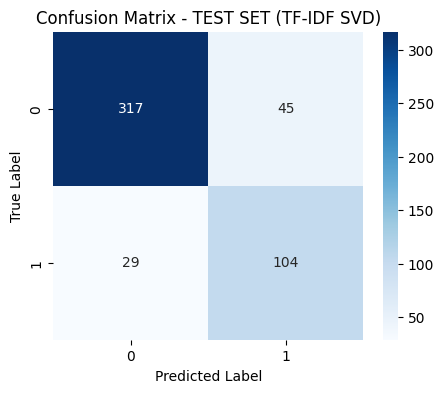

In [15]:
# Final evaluation on TEST set (not validation!)
y_pred_test = best_model.predict(X_tfidfsvd_test)
print("=== FINAL TEST SET PERFORMANCE ===")
print(classification_report(y_tfidfsvd_test, y_pred_test))

# Confusion matrix for test set
cm_test = confusion_matrix(y_tfidfsvd_test, y_pred_test)
plt.figure(figsize=(5, 4))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - TEST SET (TF-IDF SVD)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()